# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Проведем анализ данных и построим модель машинного обучения для предсказания клиентов, планирующих уйти.

In [73]:
%pip install optuna
%pip install phik
%pip install shap
%pip install --upgrade catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [74]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
import optuna
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,pointbiserialr
import phik
import warnings
import shap
from phik.report import plot_correlation_matrix
from lightgbm import LGBMClassifier,plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,f1_score

In [75]:
df_contracts = pd.read_csv('/datasets/contract_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_phone = pd.read_csv('/datasets/phone_new.csv')

In [76]:
LAST_DATE = datetime.date.fromisoformat('2020-02-01')
RANDOM_STATE = 100423
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Информация о договорах

In [77]:
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В датасете 7043 строк и 8 колонок, явных пропусков в данных нет, все столбцы имеют тип object, за исключением MonthlyCharges

In [78]:
df_contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Проверим на наличие дубликатов

In [79]:
print('Количество дубликатов = ',df_contracts.duplicated().sum())

Количество дубликатов =  0


Столбец TotalCharges - это числовой признак, поэтому логичнее привести этот столбец к типу float

In [80]:
df_contracts['TotalCharges'] = df_contracts['TotalCharges'].where(df_contracts['TotalCharges'] != ' ', None)
df_contracts['TotalCharges'] = df_contracts['TotalCharges'].astype('float')

In [81]:
print('Количество пропусков = ',df_contracts.TotalCharges.isna().sum())

Количество пропусков =  11


Посмотрим на эти пропуски

In [82]:
df_contracts[df_contracts.TotalCharges.isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [83]:
print('Количество новых клиентов = ',len(df_contracts[df_contracts['BeginDate'] == '2020-02-01']))

Количество новых клиентов =  11


Заметим, что все эти клиенты - новые, то есть они скорее всего просто не успели внести первый платеж, в таком случае логично заполнить пропуски нулями, так как оплаты действительно еще никакой не было

In [84]:
df_contracts['TotalCharges'] = df_contracts['TotalCharges'].fillna(0)

Теперь посмотрим на то, есть ли клиенты, которые ушли 1 февраля 2020 года

In [85]:
print('Количество клиентов, которые ушли 1 февраля 2020 года = ',(df_contracts['EndDate'] == '2020-02-01').sum())

Количество клиентов, которые ушли 1 февраля 2020 года =  0


Так как таких нет, то мы можем заменить 'No' в столбце EndDate на дату последней актуализации датасета - 1 февраля 2020 года

In [86]:
df_contracts['EndDate'] = df_contracts['EndDate'].replace({'No':'2020-02-01'})

Теперь заменим тип данных в столбцах EndDate и BeginDate на date

In [87]:
df_contracts['EndDate'] = pd.to_datetime(df_contracts['EndDate']).dt.date
df_contracts['BeginDate'] = pd.to_datetime(df_contracts['BeginDate']).dt.date

Посмотрим на распределение даты окончания пользования услугами

In [88]:
fig = px.bar(df_contracts[df_contracts['EndDate'] != LAST_DATE]['EndDate'].value_counts())
fig.update_layout(title = 'Распределение даты окончания пользования услугами' ,showlegend = False)
fig.update_xaxes(title = 'Дата окончания')
fig.update_yaxes(title = 'Количество пользователей')

Количество людей, которые заканчивают обслуживание, растет, это может быть связано с оттоком клиентов,например потому что меньше людей в наше время пользуются стационарной телефонной связью, или же это может быть связано с расширением компании

Посмотрим, какой процент данных составляют ушедшие пользователи

In [89]:
print('Процент ушедших пользователей = {:.2%}'.format(len(df_contracts[df_contracts['EndDate'] != LAST_DATE])/len(df_contracts)))

Процент ушедших пользователей = 15.63%


У нас есть дисбаланс в классах: ушедших пользователей всего 15% от всей выборки

Посмотрим на распределение длительности обслуживания пользователей

In [90]:
df_contracts_left_clients = df_contracts[df_contracts['EndDate'] != LAST_DATE]
service_duration = (df_contracts_left_clients['EndDate'] - df_contracts_left_clients['BeginDate'])
fig = px.box(service_duration.astype('timedelta64[M]'),width = 500, height = 500,color_discrete_sequence=['purple'])
fig.update_layout(title = 'Распределение продолжительности обслуживания', showlegend = False)
fig.update_yaxes(title = 'Количество месяцев')
fig.update_xaxes(title = '',showticklabels=False)

In [91]:
print('Минимальное количество дней обслуживания = ', service_duration.min().days)

Минимальное количество дней обслуживания =  28


Основная масса клиентов обслуживается 1.5 - 3.5 года, максимальная длительность обслуживания у ушедшего клиента - 69 месяцев (то есть около 6 лет), минимальная длительность обслуживания - примерно месяц

Проанализируем распределение ежемесячной платы за услуги

In [92]:
fig = px.histogram(df_contracts,x = 'MonthlyCharges', nbins = 200,width=900,height = 400)
fig.update_layout(title = 'Распределение ежемесячной платы за услуги')
fig.update_xaxes(title = 'Ежемесячная плата')
fig.update_yaxes(title = 'Количество людей')
fig.show()

Видим, что есть большой пик в районе 20, рассмотрим его подробнее

In [93]:
ids = df_contracts[df_contracts['MonthlyCharges'] <= 25].customerID.values
print('Процент людей с низкой ежемесячной платой = {:.2%}'.format(len(ids)/len(df_contracts)))

Процент людей с низкой ежемесячной платой = 19.96%


In [94]:
print('Количество людей с низкой ежемесячной платой, у которых подключен интернет = ',np.isin(ids,df_internet.customerID.values).sum())
print('Количество людей с низкой ежемесячной платой, у которых подключена телефонная связь = ',np.isin(ids,df_phone.customerID.values).sum())
print('Количество людей с низкой ежемесячной платой, у которых подключен и интернет, и телефонная связь = ', 
                    (np.isin(ids,df_internet.customerID.values) & np.isin(ids,df_phone.customerID.values)).sum())

Количество людей с низкой ежемесячной платой, у которых подключен интернет =  41
Количество людей с низкой ежемесячной платой, у которых подключена телефонная связь =  1365
Количество людей с низкой ежемесячной платой, у которых подключен и интернет, и телефонная связь =  0


Таким образом, около 20 процентов клиентов оплачивают ежемесячно по самому дешевому тарифу только телефонную связь или же только интернет

## 2. Персональная информация

In [95]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [96]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В этом датасете 7043 записи (на каждого клиента) и 5 признаков, явных пропусков нет

In [97]:
print('Количество дубликатов = ',df_personal.duplicated().sum())

Количество дубликатов =  0


Посмотрим на статистику по клиентам

In [98]:
fig = make_subplots(rows=1, cols=4,specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"},{"type": "pie"}]])
fig.add_trace(go.Pie(labels = df_personal.gender.value_counts().reset_index()['index'],
                      values = df_personal.gender.value_counts().reset_index()['gender']),row = 1, col = 1)

fig.add_trace(go.Pie(labels = df_personal.SeniorCitizen.replace({0:'not senior',1:'senior'}).value_counts().reset_index()['index'],
                      values = df_personal.SeniorCitizen.value_counts().reset_index()['SeniorCitizen']),row = 1, col = 2)

fig.add_trace(go.Pie(labels = df_personal.Partner.replace({'No':'doesn\'t have partner','Yes':'has partner'}).value_counts().reset_index()['index'],
                      values = df_personal.Partner.value_counts().reset_index()['Partner']),row = 1, col = 3)

fig.add_trace(go.Pie(labels = df_personal.Dependents.replace({'No':'no dependents','Yes':'has dependents'}).value_counts().reset_index()['index'],
                      values = df_personal.Dependents.value_counts().reset_index()['Dependents']),row = 1, col = 4)

fig.update_traces(textposition='inside', textinfo='percent+label',showlegend = False)
fig.update_layout(title = 'Статистика по клиентам')


Клиентов мужчин и женщин у нас поровну, как и тех, кто женат и кто нет. Примерно 16% пенсионеров и у 30% людей есть иждивенцы

## 3. Информация об интернет-услугах

In [99]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [100]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [101]:
print('Процент клиентов, которые пользуются интернет-услугами = {:.2%}'.format(len(df_internet)/len(df_personal)))

Процент клиентов, которые пользуются интернет-услугами = 78.33%


78% всех клиентов пользуются интернет-услугами, в датасете 5517 строк и 8 признаков, явных пропусков нет

In [102]:
print('Количество дубликатов = ',df_internet.duplicated().sum())

Количество дубликатов =  0


Посмотрим на статистику по подключению различных интернет-услуг

In [103]:
fig = make_subplots(rows=2, cols=4,specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"},{"type": "pie"}],
                                          [{"type": "pie"}, {"type": "pie"},{"type": "pie"},{}]],subplot_titles = df_internet.columns[1:])
for i,column in enumerate(df_internet.columns[1:]):
    fig.add_trace(go.Pie(labels = df_internet[f'{column}'].value_counts().reset_index()['index'],
                      values = df_internet[f'{column}'].value_counts().reset_index()[f'{column}'],marker =dict(colors = px.colors.sequential.RdBu)),row = (i//4)+1, col=(i%4)+1)
    
fig.update_traces(textposition='inside', textinfo='percent+label',showlegend = False)
fig.update_layout(title = 'Статистика по подключению различных интернет-услуг',height=500, width=700)

Как можно увидеть, клиенты в большинстве выбирают оптоволоконный кабель, а не телефонную линию, как минимум потому что волоконно-оптические линии более быстрые.
Всего 36% клиентов подключают блокировку небезопасных сайтов, скорее всего это в основном те клиенты, у которых есть дети с доступом к интернету. Облачное хранилище для резервного копирования подключают 44%, так же как антивирус, половина клиентов подключает стриминговое телевидение и каталог фильмов.

## 4. Информация об услугах телефонии

In [104]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [105]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [106]:
print('Процент клиентов, которые пользуются услугами телефонии = {:.2%}'.format(len(df_phone)/len(df_personal)))

Процент клиентов, которые пользуются услугами телефонии = 90.32%


In [107]:
print('Количество дубликатов = ',df_phone.duplicated().sum())

Количество дубликатов =  0


90% клиентов пользуются услугами телефонии, всего в датасете 6361 строк и 2 признака, пропусков нет, дубликатов тоже

Посмотрим, какой процент клиентов подключает свой телефон к нескольким линиям

In [108]:
print('Процент клиентов, которые подключают телефон к нескольким линиям = {:.2%}'.format(len(df_phone[df_phone.MultipleLines == 'Yes'])/len(df_phone)))

Процент клиентов, которые подключают телефон к нескольким линиям = 46.71%


In [109]:
id = df_personal[df_personal['SeniorCitizen'] == 1].customerID
print('Процент пенсионеров,пользующихся услугами телефонии, у которых подключено несколько линий = {:.2%}'
                    .format(np.isin(id,df_phone[df_phone['MultipleLines'] == 'Yes'].customerID).sum()/np.isin(id,df_phone.customerID).sum()))

Процент пенсионеров,пользующихся услугами телефонии, у которых подключено несколько линий = 64.07%


Скорее всего, пенсионерам так часто подключают несколько линий, чтобы поставить несколько телефонов в разные комнаты и пенсионеры лучше бы слышали звонок и не нужно было бы на каждый звонок идти в другую комнату

## Вывод 
Была проведена предобработка данных: проверка на дубликаты, приведение к нужным типам данных, проверка на пропуски и их заполнение 

Был проведен первичный анализ данных, в ходе которого были сделаны следующие выводы:
1. Количество ушедших людей растет со временем
2. В выборке имеется дисбаланс - 15% от выборки составляют ушедшие клиенты
3. Основная масса ушедших клиентов обслуживалась 1.5- 3.5 года, минимальный срок обслуживания - месяц, максимальный - 6 лет
4. 20% клиентов пользуются самым дешевым тарифом, и пользуются или только интернет-услугами, или только телефонией
5. Мужчин и женщин в выборке поровну, так же как и женатых и неженатых, 30% с иждивенцами, 16% пенсионеры
6. 78% всех клиентов пользуются интернет услугами
7. Большинство клиентов используют Fiber optic, не подключают блокировку небезопасных сайтов и не подключают выделенную линию техподдержки
8. 90% всех клиентов пользуются услугами телефонии
9. 46% клиентов телефонии подключают несколько линий
10. 64% пенсионеров, которые пользуются телефонией, подключают несколько линий

## План дальнейшей работы

**Анализ данных и подготовка признаков**:

1. Объединение выборок в один датасет
2. Обработать образовавшиеся пропуски
3. Создать новые признаки
4. Анализ признаков на мультиколлинеарность
5. Посмотреть на корреляцию признаков и таргета
6. Проанализировать распределение признаков в зависимости от таргета
7. Проверка статистических гипотез
8. Вывод

**Построение модели**:

1. Кодирование категориальных признаков
2. Подбор параметров для 2-3 моделей (например, LightGBM, Catboost, Random Forest) с помощью RandomizedSearchCV или Optuna
3. Выбор итоговой модели по кросс-валидации
4. Анализ важности признаков
5. Проверка качества выбранной модели на тесте
6. Анализ матрицы ошибок
7. Построение roc-кривой
8. Вывод


# Анализ данных и подготовка признаков

Объединим выборки в один датасет

In [110]:
df = df_contracts.copy()
df = df.merge(df_personal,how = 'left',on = 'customerID')
df = df.merge(df_internet,how = 'left',on = 'customerID')
df = df.merge(df_phone,how = 'left',on = 'customerID')

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [112]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
BeginDate,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01
EndDate,2020-02-01,2020-02-01,2020-02-01,2020-02-01,2020-02-01
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check
MonthlyCharges,29.85,56.95,53.85,42.3,70.7
TotalCharges,31.04,2071.84,226.17,1960.6,353.5
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0


Так как не все клиенты пользуются и телефонией, и интернет-услугами, то в нашем объединенном датасете появились пропуски, так как пропуски образовались в категориальных столбцах, то заполним их специальным значением 'Do not use'

In [113]:
df = df.fillna('Do not use')

Наш целевой признак - ушел или нет клиент, поэтому построим таргет, основываясь на столбце 'EndDate', если клиент ушел - в таргете будет 1, если нет - 0

In [114]:
target = (df['EndDate'] != LAST_DATE).astype('int')

Удалим колонки EndDate и BeginDate, вместо них построим более содержательный для этой задачи признак, который не будет привязан к конкретной дате и не будет утечкой таргета - количество дней обслуживания 

In [115]:
df['service_duration'] = (df['EndDate'] - df['BeginDate']).dt.days

In [116]:
df = df.drop(['BeginDate','EndDate'],axis = 1)

Также удалим колонку customerID, так как этот признак бесполезен для предсказания оттока, ведь этот ID уникален для каждого клиента

In [117]:
df = df.drop(['customerID'],axis = 1)

Проанализируем корреляцию оставшихся признаков, для численных признаков будем использовать корреляцию Пирсона, для категориальных - phik, будем также анализировать статистическую значимость полученных коэффициентов

In [118]:
numeric = ['MonthlyCharges','TotalCharges','service_duration']
categorical = df.drop(numeric,axis = 1).columns

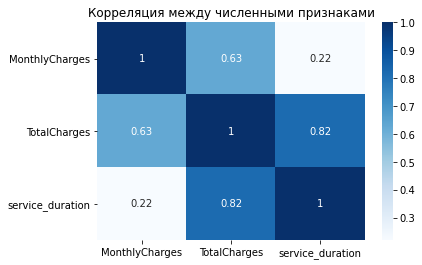

In [119]:
ax = sns.heatmap(df[numeric].corr(method = 'pearson'),annot = True, cmap = 'Blues')
ax.set_title('Корреляция между численными признаками');

In [120]:
pvalues = pd.DataFrame(index = numeric, columns = numeric)
for c1 in numeric:
    for c2 in numeric:
        pvalues[c1][c2] = pearsonr(df[c1],df[c2]).pvalue
display(pvalues)

,MonthlyCharges,TotalCharges,service_duration
MonthlyCharges,0.0,0.0,0.0
TotalCharges,0.0,0.0,0.0
service_duration,0.0,0.0,0.0


Коэффициент корреляции достаточно высокий и pvalue < 0.05 у взаимосвязи между TotalCharges и service_duration, и средний коэффициент корреляции с pvalue < 0.05 между MonthlyCharges и TotalCharges, следовательно между этими признаками есть статистически значимая связь, что логично, потому что TotalCharges - это общее количество денег, потраченных на услуги, а MonthlyCharges - это сколько клиент тратит ежемесячно, а также чем больше клиент заплатил тем, скорее всего, он дольше пользуется услугами

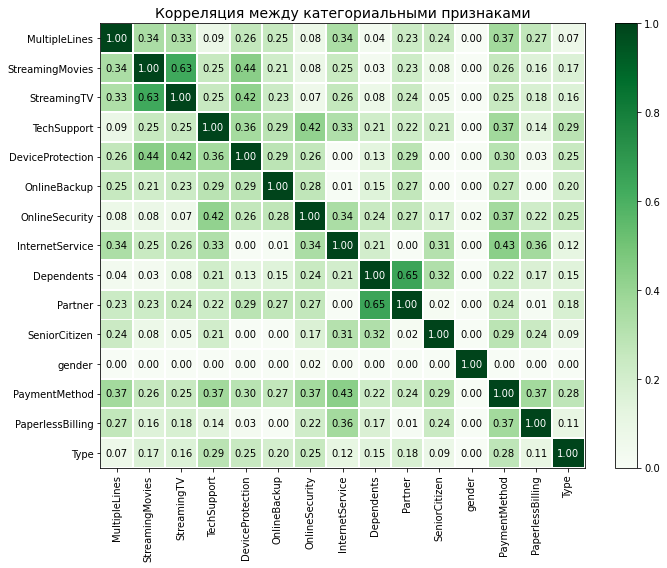

In [121]:
cat_corr = df[categorical].replace({'Do not use':None}).phik_matrix(interval_cols = [])
plot_correlation_matrix(cat_corr.values, 
                        x_labels=cat_corr.columns, 
                        y_labels=cat_corr.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title= "Корреляция между категориальными признаками",  
                        figsize=(10, 8))

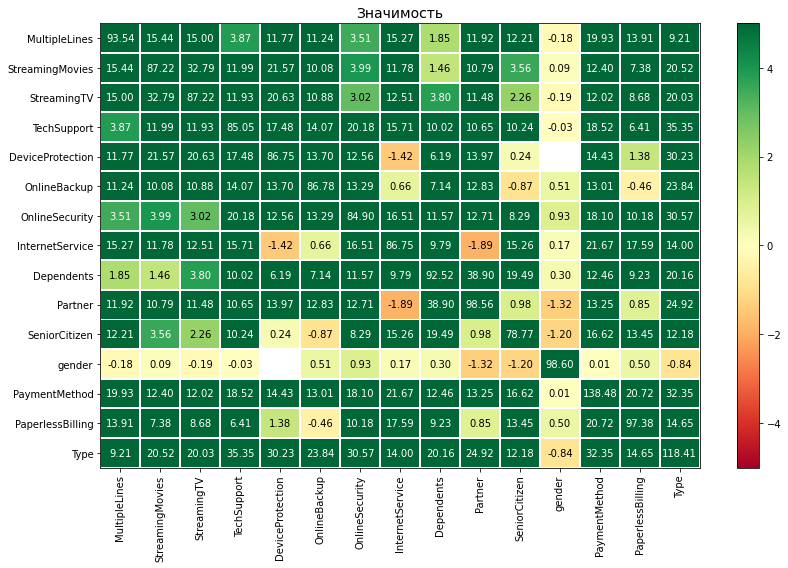

In [122]:
significance = df[categorical].replace({'Do not use':None}).significance_matrix(interval_cols=[])
plot_correlation_matrix(significance.fillna(0).values, 
                        x_labels=significance.columns, 
                        y_labels=significance.index, 
                        vmin=-5, vmax=5, title="Значимость", 
                        figsize=(12, 8))

Среднюю связь имеют столбцы StreamingTV и StreamingMovies, скорее всего люди в большинстве если покупают одну из этих услуг, покупают и другую. Также среднюю связь имеют столбцы Dependents и Partner, что логично, потому что у большинства семей есть дети, остальные столбцы либо совсем независимы, либо имеют совсем нелинейную или слабую связь

Посмотрим на корреляцию признаков и таргета, в случае с корреляцией таргета и числовых признаков, будем использовать бисериальный коэффициент корреляции

In [123]:
target_corr = pd.DataFrame(index = ('corr','pvalue'), columns = numeric)
for c in numeric:
    target_corr[c] = [*pointbiserialr(df[c],target)]
display(target_corr.apply(lambda x: x.map('{:.3f}'.format)))

,MonthlyCharges,TotalCharges,service_duration
corr,0.154,0.052,0.017
pvalue,0.000,0.000,0.164


Очень слабую связь с таргетом имеет столбец service_duration, мы даже не можем отвергнуть гипотезу о нескоррелированности, возможно, он будет иметь малый вес в модели

In [124]:
target_corr = pd.DataFrame(index = ('corr','pvalue'), columns = categorical)
for c in categorical:
    target_corr[c] = phik.phik_from_array(df[c],target),phik.significance_from_array(df[c],target)[0]
display(target_corr.apply(lambda x: x.map('{:.5f}'.format)).T)

,corr,pvalue
Type,0.09401,0.00000
PaperlessBilling,0.08340,0.00000
PaymentMethod,0.21483,0.00000
gender,0.00858,0.24314
SeniorCitizen,0.08616,0.00000
Partner,0.22669,0.00000
Dependents,0.04687,0.00585
InternetService,0.05662,0.00000
OnlineSecurity,0.05866,0.00000
OnlineBackup,0.08970,0.00000


Очень слабую связь с таргетом имеет столбец gender, что логично, так как этот признак вообще не имел никакой взаимосвязи с другими признаками, утечки таргета также нет в данных, так как коэффициенты корреляции достаточно низкие

Посмотрим на распределение признаков в зависимости от таргета

In [125]:
fig = make_subplots(cols=len(numeric), rows=1,subplot_titles=numeric)
for i,feature in enumerate(numeric):
    fig.add_trace(go.Box(y = df[target == 1][feature],name = 'left clients'), col = i+1, row = 1)
    fig.add_trace(go.Box(y = df[target == 0][feature],name = 'remaining clients'), col = i+1, row = 1)
fig.update_layout(showlegend = False, title = 'Распределение численных признаков в зависимости от таргета')
fig.show()

По признаку service_duration мы видим, что в основном уходят клиенты после 600-1200 дней, разброс в количестве дней обслуживания у оставшихся клиентов гораздо больше, то есть недавно появившиеся клиенты в основном остаются и те кто уже долгое время обслуживается также предпочитают продолжать пользоваться услугами.
Анализируя графики для MonthlyCharges и TotalCharges, можно сказать, что те кто мало платит ежемесячно, в основном остаются, также у оставшихся клиентов больше выбросы в TotalCharges, возможно это те клиенты, кто уже очень долго пользуется услугами. Те кто ушел, платили больше в месяц, чем те, кто остались, возможно они нашли более выгодные тарифы в другой компании.  

In [126]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1:'Yes',0:'No'})

In [127]:
fig = make_subplots(rows=3, cols= 5,specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}],
                                          [{"type": "pie"}, {"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}],
                                          [{"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}]],subplot_titles = categorical,
                                          vertical_spacing=0.1, horizontal_spacing = 0.01)
for i,column in enumerate(categorical):
    fig.add_trace(go.Pie(labels = df[target == 1][f'{column}'].value_counts().reset_index()['index'],
                      values = df[target == 1][f'{column}'].value_counts().reset_index()[f'{column}'],marker =dict(colors = px.colors.sequential.Blugrn)),row = (i//5)+1, col=(i%5)+1)
    
fig.update_traces(textposition='inside', textinfo='percent+label',showlegend = False)
fig.update_layout(title = 'Распределение категориальных признаков у ушедших клиентов',height=700, width=1000)

In [128]:
fig = make_subplots(rows=3, cols= 5,specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}],
                                          [{"type": "pie"}, {"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}],
                                          [{"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}]],subplot_titles = categorical,
                                          vertical_spacing=0.1, horizontal_spacing = 0.01)
for i,column in enumerate(categorical):
    fig.add_trace(go.Pie(labels = df[target == 0][f'{column}'].value_counts().reset_index()['index'],
                      values = df[target == 0][f'{column}'].value_counts().reset_index()[f'{column}'],marker =dict(colors = px.colors.sequential.Blugrn)),row = (i//5)+1, col=(i%5)+1)
    
fig.update_traces(textposition='inside', textinfo='percent+label',showlegend = False)
fig.update_layout(title = 'Распределение категориальных признаков у оставшихся клиентов',height=700, width=1000)

Оставшиеся клиенты в большинстве своем пользуются помесячным типом оплаты, процент людей не пользующихся интернет-услугами у оставшихся клиентов выше, чем у ушедших. А также среди ушедших клиентов больше людей предпочитали оптоволокно, нежели среди оставшихся. Ушедшие клиенты имели гораздо больший процент пользующихся стриминговым телевидением и каталогом фильмов, а также несколькими телефонными линиями

## Выводы:
Датасеты были объединены в один, образовавшиеся пропуски в категориальных переменных заполнены специальным значением 'Do not use', вместо столбцов EndDate и BeginDate сформирован новый признак - service_duration, построен бинарный таргет, удален ненужный столбец customerID, в процессе анализа были сделаны следующие выводы:

1. Между service_duration и TotalCharges есть достаточно сильная статистически значимая связь
2. Среднюю связь имеют столбцы StreamingTV и StreamingMovies, скорее всего люди в большинстве если покупают одну из этих услуг, покупают и другую. 
3. Среднюю связь имеют столбцы Dependents и Partner
4. Очень слабую связь с таргетом имеет столбец gender
5. В основном уходят клиенты после 600-1200 дней, разброс в количестве дней обслуживания у оставшихся клиентов гораздо больше, то есть недавно появившиеся клиенты в основном остаются и те кто уже долгое время обслуживается также предпочитают продолжать пользоваться услугами.
6. Те кто мало платит ежемесячно, в основном остаются
7. У оставшихся клиентов больше выбросы в TotalCharges, возможно это те клиенты, кто уже очень долго пользуется услугами. 
8. Те кто ушел, платили больше в месяц, чем те, кто остались, возможно они нашли более выгодные тарифы в другой компании.  
9. Оставшиеся клиенты в большинстве своем пользуются помесячным типом оплаты
10. Процент людей не пользующихся интернет-услугами у оставшихся клиентов выше, чем у ушедших, возможно они нашли тариф на интернет-услуги лучше
11. Среди ушедших клиентов больше людей предпочитали оптоволокно, нежели среди оставшихся. 
12. Ушедшие клиенты имели гораздо больший процент пользующихся стриминговым телевидением и каталогом фильмов, а также несколькими телефонными линиями

## Построение модели

Для кодирования категориальных признаков будем использовать OrdinalEncoder

In [129]:
enc = OrdinalEncoder()
preprocess = ColumnTransformer(transformers=[('cat', enc, list(categorical))],remainder='passthrough')
pipeline_lgbm = make_pipeline(preprocess,LGBMClassifier())
pipeline_forest = make_pipeline(preprocess,RandomForestClassifier())

Поделим выборку на тренировочную и тестовую в отношении 3:1, так как у нас есть дисбаланс, то установим stratify

In [130]:
train_features,test_features, train_target,test_target = train_test_split(df,target,test_size=0.25,random_state=RANDOM_STATE, shuffle=True, stratify = target)

Подберем наилучшие гиперпараметры для каждой из моделей - LightGBM, Catboost, RandomForest с помощью Optuna

In [131]:
def objective_lgbm (trial):
    global pipeline_lgbm
    n_est = trial.suggest_int('n_estimators',20,146,7)
    num_leaves = trial.suggest_int('num_leaves',15,39,3)
    depth = trial.suggest_int('max_depth',7,49,3)
    min_samples_leaf = trial.suggest_int('min_child_samples',2,38,3)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 1.0,step = 0.05)
    params = dict(lgbmclassifier__random_state=RANDOM_STATE, lgbmclassifier__is_unbalance = True,
                                  lgbmclassifier__n_estimators = n_est, lgbmclassifier__max_depth = depth, 
                                  lgbmclassifier__learning_rate = learning_rate,
                                  lgbmclassifier__min_child_samples=min_samples_leaf,
                                  lgbmclassifier__num_leaves = num_leaves)
    pipeline_lgbm = pipeline_lgbm.set_params(**params)
    
    score = cross_validate(pipeline_lgbm,train_features,train_target,scoring = 'roc_auc',cv = 4, fit_params = 
                    {'lgbmclassifier__categorical_feature' : list(categorical),
                     'lgbmclassifier__feature_name' : list(categorical) + list(numeric)})['test_score'].mean()
    return score

In [132]:
# study_lgbm = optuna.create_study(direction="maximize",sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE))
# study_lgbm.optimize(objective_lgbm, n_trials = 200, n_jobs = -1)
# print(study_lgbm.best_trial)

In [133]:
def objective_cat (trial):
    iter = trial.suggest_int('iterations',20,200,7)
    depth = trial.suggest_int('max_depth',5,16,1)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf',2,38,3)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 1.0,step = 0.05)
    balance = trial.suggest_categorical('auto_class_weights',['Balanced','SqrtBalanced'])
    model = CatBoostClassifier(random_state=RANDOM_STATE, iterations = iter, max_depth = depth, learning_rate = learning_rate,
                            min_data_in_leaf=min_data_in_leaf, auto_class_weights = balance,logging_level='Silent')
    
    score = cross_validate(model,train_features,train_target,scoring = 'roc_auc',cv = 4, fit_params = 
                           {'cat_features' : list(categorical)})['test_score'].mean()
    return score

In [134]:
# study_cat = optuna.create_study(direction="maximize",sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE))
# study_cat.optimize(objective_cat, n_trials = 100, n_jobs = -1)
# print(study_cat.best_trial)

In [135]:
def objective_forest (trial):
    global pipeline_forest
    n_est = trial.suggest_int('n_estimators',20, 200,7)
    max_depth = trial.suggest_int('max_depth',5,39,3)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2,38,3)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20,1)
    params = dict(randomforestclassifier__random_state=RANDOM_STATE,
                  randomforestclassifier__n_estimators = n_est,
                  randomforestclassifier__max_depth = max_depth,
                  randomforestclassifier__min_samples_leaf=min_samples_leaf,
                  randomforestclassifier__min_samples_split = min_samples_split,
                  randomforestclassifier__class_weight = 'balanced')
    pipeline_forest = pipeline_forest.set_params(**params)
    score = cross_validate(pipeline_forest,train_features,train_target,scoring = 'roc_auc',cv = 4)['test_score'].mean()
    return score

In [136]:
# study_forest = optuna.create_study(direction="maximize",sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE))
# study_forest.optimize(objective_forest, n_trials = 200, n_jobs = -1)
# print(study_forest.best_trial)

Лучший результат показала модель LightGBM 

In [137]:
best_params = dict(lgbmclassifier__random_state=RANDOM_STATE, lgbmclassifier__is_unbalance = True,
                                  lgbmclassifier__n_estimators = 146, lgbmclassifier__max_depth = 43, 
                                  lgbmclassifier__learning_rate = 0.35,
                                  lgbmclassifier__min_child_samples=8,
                                  lgbmclassifier__num_leaves = 27)
pipeline_lgbm = pipeline_lgbm.set_params(**best_params)
pipeline_lgbm = pipeline_lgbm.fit(train_features,train_target,lgbmclassifier__categorical_feature = list(categorical),
                  lgbmclassifier__feature_name = list(categorical) + list(numeric));

Проверим качество модели на тестовой выборке

In [138]:
print('Roc-auc на тестовой выборке = ',roc_auc_score(test_target,pipeline_lgbm.predict_proba(test_features)[:,1]))
print('Accuracy на тестовой выборке = ',accuracy_score(test_target,pipeline_lgbm.predict(test_features)))

Roc-auc на тестовой выборке =  0.9070304661690932
Accuracy на тестовой выборке =  0.8926746166950597


Проанализируем важность признаков в выбранной модели

In [139]:
encoding_order = list(map(lambda x: tuple(x),OrdinalEncoder().fit(train_features[categorical]).categories_))
encoding_dict = dict((categorical[i],encoding_order[i]) for i in range(len(categorical)))
display(encoding_dict)

{'Type': ('Month-to-month', 'One year', 'Two year'),
 'PaperlessBilling': ('No', 'Yes'),
 'PaymentMethod': ('Bank transfer (automatic)',
  'Credit card (automatic)',
  'Electronic check',
  'Mailed check'),
 'gender': ('Female', 'Male'),
 'SeniorCitizen': ('No', 'Yes'),
 'Partner': ('No', 'Yes'),
 'Dependents': ('No', 'Yes'),
 'InternetService': ('DSL', 'Do not use', 'Fiber optic'),
 'OnlineSecurity': ('Do not use', 'No', 'Yes'),
 'OnlineBackup': ('Do not use', 'No', 'Yes'),
 'DeviceProtection': ('Do not use', 'No', 'Yes'),
 'TechSupport': ('Do not use', 'No', 'Yes'),
 'StreamingTV': ('Do not use', 'No', 'Yes'),
 'StreamingMovies': ('Do not use', 'No', 'Yes'),
 'MultipleLines': ('Do not use', 'No', 'Yes')}

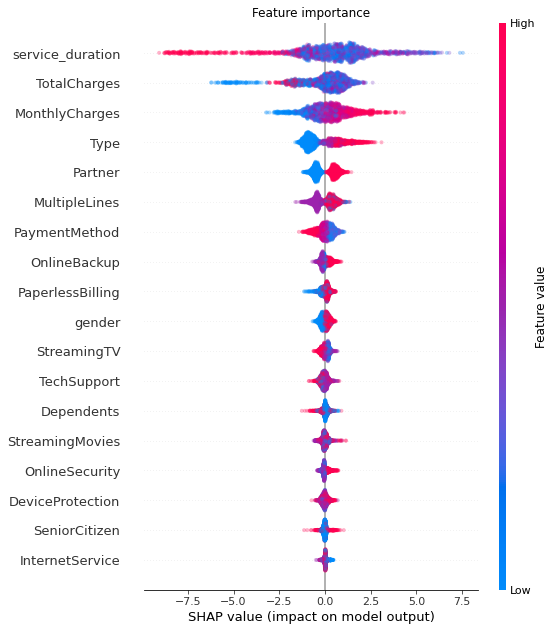

In [140]:
explainer = shap.TreeExplainer(pipeline_lgbm['lgbmclassifier'])
observations = pipeline_lgbm['columntransformer'].transform(test_features)
shap_values = explainer.shap_values(observations)
shap.summary_plot(shap_values[1], observations,alpha=0.3,show = False,feature_names = list(categorical) + list(numeric))
plt.title('Feature importance')
plt.show()

Мы видели различия в распределении числовых признаков в зависимости от таргета, и все 3 числовых признака имеют большой вес в нашей модели, на первом месте - количество дней обслуживания, на втором - общая плата, на третьем - ежемесячная плата. Большие значения service_duration у некоторых сильно влияли на предсказания в пользу оставшихся клиентов, значения чуть ближе к середине влияли иногда сильно на предсказания в пользу ушедших клиентов. В случае с общей платой, малые значения в некоторых случаях давали сильное влияние классу оставшихся клиентов, как и совсем большие значения. В случае с месячной платой, большие значения свидетельствовали о классе ушедших клиентов, а малые - о классе оставшихся. В случае с категориальными переменными самыми важными оказались: тип оплаты (временной), наличие партнера, использование нескольких выделенных линий, способ оплаты. Помесячный тип оплаты часто был индикатором класса оставшихся клиентов, а самый долгосрочнй тип (2 года) был индикатором класса ушедших клиентов. Со столбцом о наличии партнера все просто: есть партнер - индикатор ушедшего клиента, нет партнера - оставшегося. Похожая ситуация и с признаком об использовании нескольких линий: не использование услуг телефонии или не использование выделенных линий- клиент не уходит, использование - клиент уходит. Способ оплаты: mailed check - клиент остается, bank transfer - уходит. Все это согласуется с выводами, сделанными ранее с помощью графиков.

Построим roc-кривую

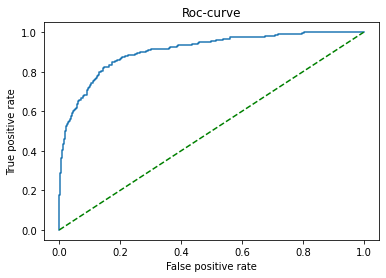

In [141]:
fpr, tpr, _ = roc_curve(test_target,pipeline_lgbm.predict_proba(test_features)[:,1])
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1],'g--')
plt.title('Roc-curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

Построим и проанализируем матрицу ошибок

In [142]:
error_matrix = pd.DataFrame(confusion_matrix(test_target,pipeline_lgbm.predict(test_features)),index = ['real_neg','real_pos'], columns=['pred_neg','pred_pos'])
color = sns.light_palette("blue", as_cmap=True)
error_matrix=error_matrix.style.background_gradient(cmap=color)
error_matrix = error_matrix.set_properties(width = '200px',height = '120px',**{'text-align' :'center','font-size': '15pt'})
display(error_matrix)

,pred_neg,pred_pos
real_neg,1399,87
real_pos,102,173


В 102 случае мы не смогли "заметить" ушедших клиентов, в 87 случае мы предсказали, что клиент уходит, хотя на самом деле это не так. Так как в данных был дисбаланс, мы лучше предсказываем клиентов, которые остаются, однако можно с помощью уменьшения порога увеличить true positive rate, но при этом увеличить false positive rate.

## Вывод
1. Категориальные признаки были закодированы с помощью Ordinal Encoding
2. С помощью Optuna для 3 моделей : LightGBM, Catboost, RandomForest были подобраны наилучшие гиперпараметры по кросс-валидации
3. Для выбора была использована метрика roc-auc, так как она не чувствительна к дисбалансу, который присутствует в наших данных
4. Лучший результат показала модель LightGBM с гиперпараметрами : n_estimators = 146,num_leaves = 27,max_depth = 43,min_child_samples = 8,learning_rate =0.35
5. На тестовой выборке она показала хорошее качество: roc-auc = 0.9, accuracy = 0.89
6. Все 3 числовых признака имеют большой вес в нашей модели, на первом месте - количество дней обслуживания, на втором - общая плата, на третьем - ежемесячная плата.
7. В случае с категориальными переменными самыми важными оказались: тип оплаты (временной), наличие партнера, использование нескольких выделенных линий, способ оплаты.
8. Так как в данных был дисбаланс, мы лучше предсказываем клиентов, которые остаются, однако можно с помощью уменьшения порога увеличить true positive rate, но при этом увеличить false positive rate.

## Отчет

**Поставленная задача**: по персональным данным клиентов, информации об их тарифах и договорах научиться прогнозировать отток клиентов.

**Ключевые шаги в решении задачи**:  
1. Анализ и предобработка каждого из датасетов (информация о договорах, персональные данные, информация об интернет-услугах, информация об услугах телефонии)    
2. Объединение датасетов в один + обработка образовавшихся пропусков  
3. Формирование таргета по столбцу 'EndDate', преобразование столбцов 'EndDate' и 'BeginDate' в более информативный - 'service_duration', удаление 'customerID', 'EndDate', 'BeginDate'  
4. Анализ корреляции признаков между собой (для численных признаков - корреляция Пирсона, для категориальных - phik) с учетом статистической значимости  
5. Анализ корреляции признаков с таргетом (бисериальный коэффициент корреляции) с учетом статистической значимости  
6. Анализ распределения признаков в зависимости от таргета  
7. Построение pipeline для дальнейшего подбора наилучших гиперпараметров для моделей: LightGBM, Catboost, Random Forest, с использованием OrdinalEncoder для категориальных признаков  
8. Разделение выборки на тренировочную и тестовую в отношении 3:1  
9. Подбор наилучших гиперпараметров с помощью Optuna и кросс-валидации  
10. Выбор наилучшей модели  
11. Проверка качества выбранной модели на тестовой выборке (метрики roc-auc и accuracy)  
12. Анализ важности признаков выбранной модели  
13. Построение и анализ матрицы ошибок и roc-кривой  

**Признаки, используемые для обучения модели**:    
+ service_duration – длительность пользования услугами в днях,  
+ Type – тип оплаты: ежемесячный, годовой и тд,  
+ PaperlessBilling – электронный платёжный документ,  
+ PaymentMethod – способ оплаты,  
+ MonthlyCharges – ежемесячные траты на услуги,  
+ TotalCharges – всего потрачено денег на услуги,   
+ Dependents – наличие иждивенцев,  
+ Senior Citizen – наличие пенсионного статуса по возрасту,  
+ Partner – наличие супруга(и),  
+ MultipleLines – наличие возможности ведения параллельных линий во
время звонка,  
+ gender – пол,  
+ InternetService – тип подключения к интернету,  
+ OnlineSecurity – блокировка небезопасных сайтов,   
+ OnlineBackup – облачное хранилище файлов для резервного копирования данных,  
+ DeviceProtection – антивирус,  
+ TechSupport – выделенная линия технической поддержки,  
+ StreamingTV – стриминговое телевидение,  
+ StreamingMovies – каталог фильмов,  

**Итоговая модель**: 
 
LightGBM с гиперпараметрами:  

```
random_state = 100423,  
is_unbalance = True,  
n_estimators = 146,  
max_depth = 43,  
learning_rate = 0.35,  
min_child_samples = 8,  
num_leaves = 27

``` 
  
Roc-auc на тестовой выборке = 0.9  
Accuracy на тестовой выборке = 0.89  

**Важность признаков**:   
 
1. Количество дней обслуживания,  
2. Общая плата,  
3. Ежемесячная плата,  
4. Тип оплаты (временной),  
5. Наличие партнера,  
6. Использование нескольких выделенных линий,  
7. Способ оплаты.  

Все пункты плана были выполнены, трудностей в процессе работы не возникло
